In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp feature_eng

# Feature engineering

In [ ]:
#hide
import matplotlib.pyplot as plt
from nbdev.showdoc import *

In [ ]:
#export
import time
import pandas as pd
import numpy as np
import random

from fastcore.test import *
from time_series_segmentation import *

In [ ]:
df_train, df_test, df_sample = get_liverpool_ion_data()

data folder already exists


In [ ]:
df_train

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0
...,...,...,...
4999995,499.9996,2.9194,7
4999996,499.9997,2.6980,7
4999997,499.9998,4.5164,8
4999998,499.9999,5.6397,9


In [ ]:
# export
def add_seq_indicator(data_index, seq_len=20):
    '''
    function to be used with apply in df.
    Assings sequence labels to sections of the data which allows us to randomly train/val/test splitt the subsequences.
    the acctual splitt

    Parameters:

    Output:

    '''
    return np.int(np.ceil((data_index.name+1)/seq_len))

In [ ]:
# export
def dataframe_split(data, fraction = 0.1, random_state = 42, sep_col='seq_idx'):
    '''
    Creates a random split by the desired column
    '''
    if sep_col not in data.columns:
        data[sep_col] = data.apply(add_seq_indicator,seq_len=1000, axis=1)

    random.seed(random_state)
    sequence_numbers = data[sep_col].unique().tolist()
    k = int(np.ceil(data[sep_col].nunique()*fraction))
    split_list = random.sample(sequence_numbers, k=k)
    test = data.loc[data[sep_col].isin(split_list), :]
    train = data.drop(test.index)
    return train, test

In [ ]:
train_train, train_val = dataframe_split(df_train, fraction = 0.1, random_state = 42, sep_col='seq_idx')

(<matplotlib.axes._subplots.AxesSubplot at 0x21f45dd7a88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21f45dd7a88>)

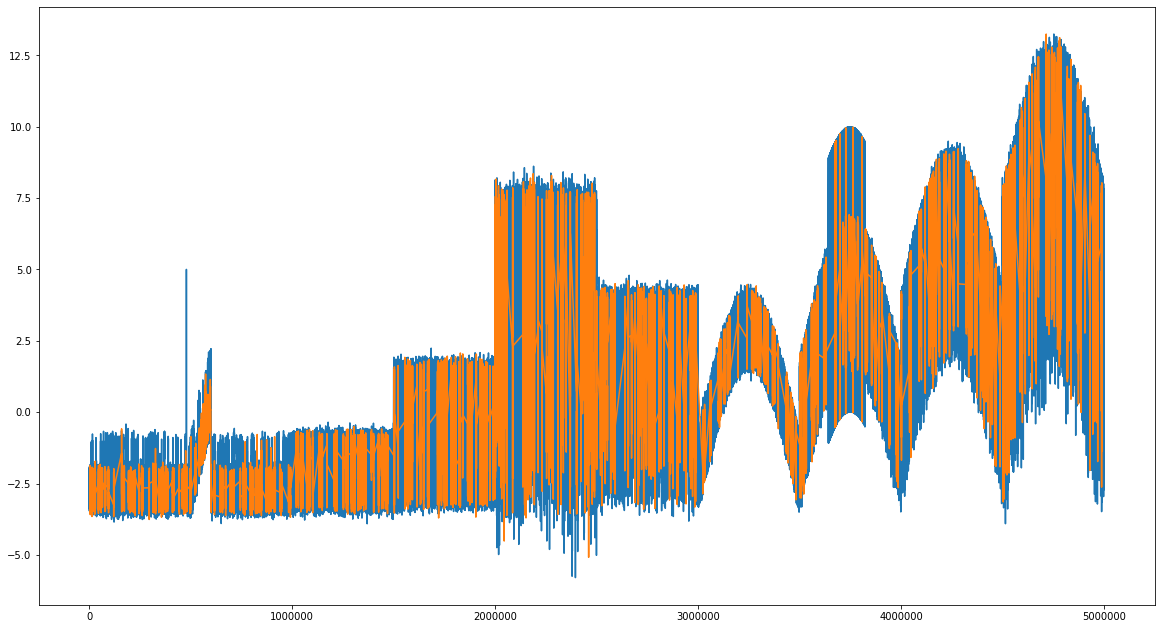

In [ ]:
train_train.loc[:,'signal'].plot(figsize=(20,11)), train_val.loc[:,'signal'].plot(figsize=(20,11))

In [ ]:
train_train.shape, train_val.shape

((4500000, 4), (500000, 4))

In [ ]:
# export
def feature_engineering_std(data, on_column, span=1):
    '''
    standard deviation of the bidirectional exponentially weighted mean
    
    Parameter:
    data: [pandas.DataFrame] in put data frame
    on_column: [string] on which column the operation should take place
    span: [integer] the span of the expo exponentially weighted mean
    
    Out:
    new feature, column of values that can be added to the data frame
    
    
    '''
    data_new = (data[on_column].ewm(span=span).std()+data[on_column].sort_index(ascending=False).ewm(span=span).std())/2
    data_new2 = data_new.fillna(method='ffill').fillna(method='bfill')
    assert (data_new2.isnull().sum().sum() == 0), 'check for NaNs in dtaframe'

    return data_new2

In [ ]:
# export
def feature_engineering_mean(data, on_column, span=1):
    '''
    mean value of the bidirectional exponentially weighted mean
    
    Parameter:
    data: [pandas.DataFrame] in put data frame
    on_column: [string] on which column the operation should take place
    span: [integer] the span of the expo exponentially weighted mean
    
    Out:
    new feature, column of values that can be added to the data frame
    
    
    '''
    data_new = ((data[on_column].ewm(span=span).mean()+
                                    data[on_column].sort_index(ascending=False).ewm(span=span).mean())/2)
    assert (data_new.isnull().sum().sum() == 0), 'check for NaNs in dtaframe'

    return data_new

In [ ]:
# export
def feature_engineering_drift(data, on_column, span=1):
    '''
    Local drift comparing the current value to the bidirectional exponentially weighted mean
    
    Parameter:
    data: [pandas.DataFrame] in put data frame
    on_column: [string] on which column the operation should take place
    span: [integer] the span of the expo exponentially weighted mean
    
    Out:
    new feature, column of values that can be added to the data frame
    
    
    '''
    data_new = data[on_column]-feature_engineering_mean(data, on_column, span)
    assert (data_new.isnull().sum().sum() == 0), 'check for NaNs in dtaframe'
    return data_new

In [ ]:
# export
def get_features_basic(data):
    '''
    Basic example of combining several features:
    
    Thess example spans where chosen when working on the Liverpool Ion Channel
    dataset from Kaggle
    
    '''
    data.loc[:,'new_mean'] = feature_engineering_mean(data,'signal', span=10)
    data.loc[:,'std_long'] = feature_engineering_std(data, 'new_mean', span=1000)
    data.loc[:,'no_drift'] = feature_engineering_drift(data,'signal', span=1000)
    data.loc[:,'opt'] = (data.loc[:,'no_drift']+(8*data.loc[:,'std_long']))
    
    return data

In [ ]:
train_train = get_features_basic(train_train)
train_val = get_features_basic(train_val)

C:\Users\immo\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\immo\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(<matplotlib.axes._subplots.AxesSubplot at 0x21f45d5f708>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21f45d5f708>)

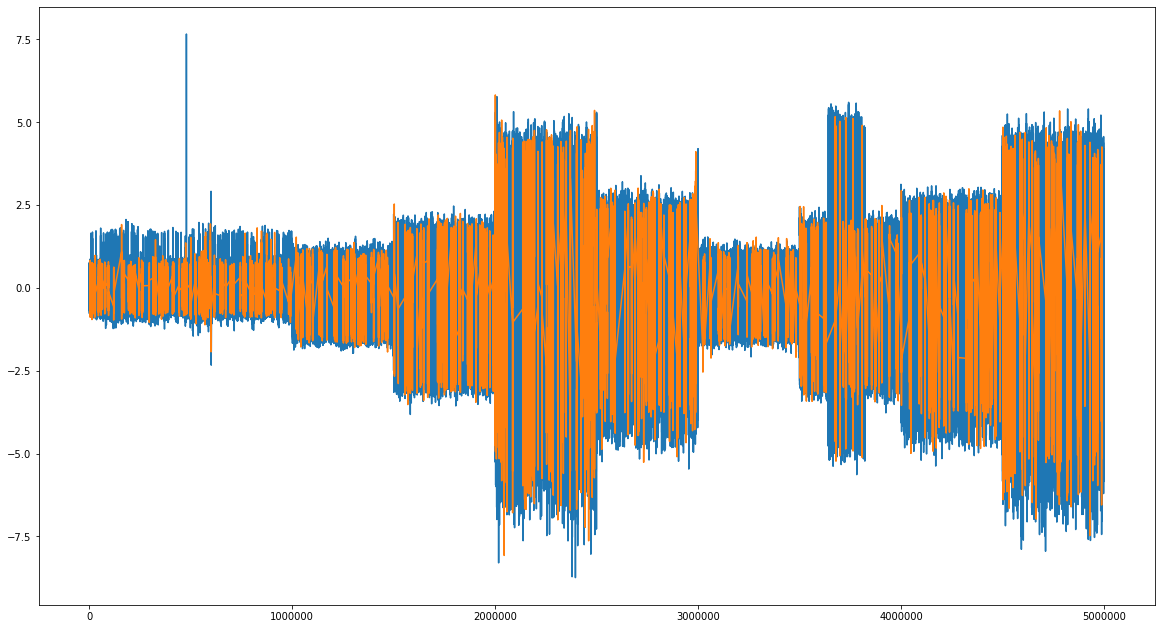

In [ ]:
train_train.loc[:,'no_drift'].plot(figsize=(20,11)), train_val.loc[:,'no_drift'].plot(figsize=(20,11))

(<matplotlib.axes._subplots.AxesSubplot at 0x21f0ee67ec8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21f0ee67ec8>)

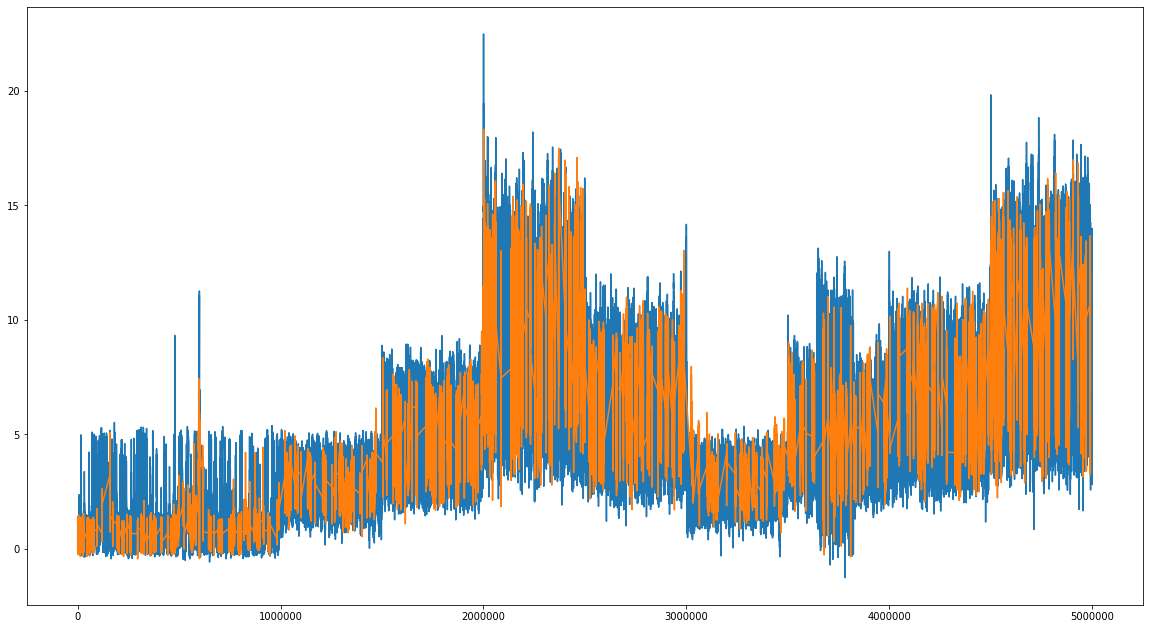

In [ ]:
train_train.loc[:,'opt'].plot(figsize=(20,11)), train_val.loc[:,'opt'].plot(figsize=(20,11))

(<matplotlib.axes._subplots.AxesSubplot at 0x21f0eed85c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21f0eed85c8>)

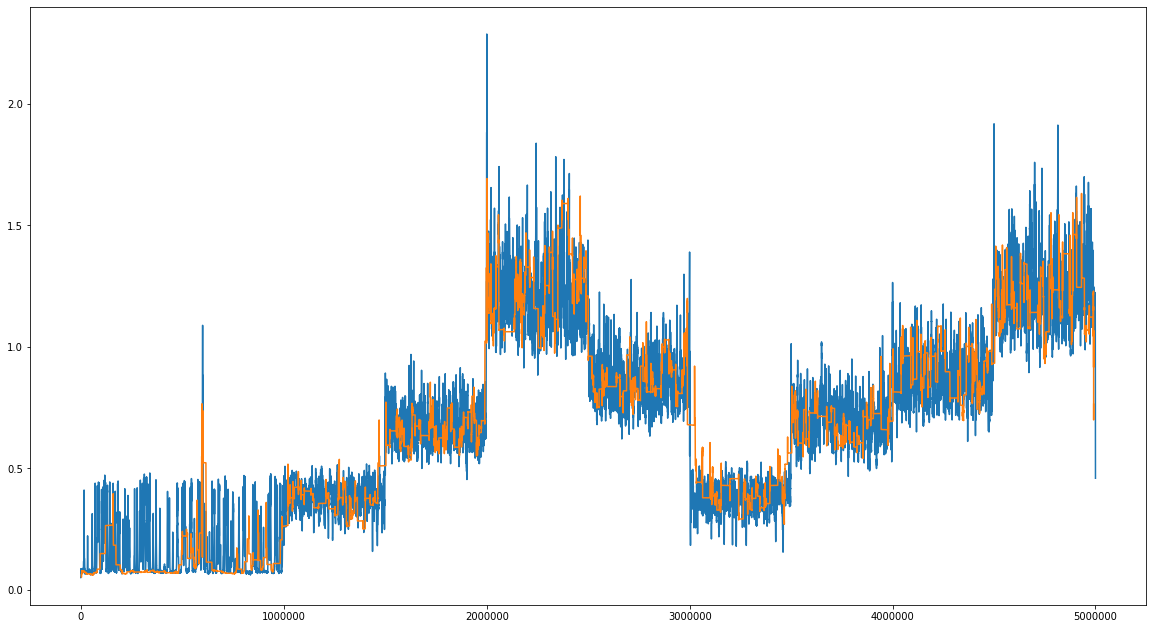

In [ ]:
train_train.loc[:,'std_long'].plot(figsize=(20,11)), train_val.loc[:,'std_long'].plot(figsize=(20,11))

In [ ]:
def creat_cat_label_columns(data, label_column):
    data = pd.concat([data, pd.get_dummies(data[label_column], prefix=f'{label_column}_cat')], axis=1)
    return data

In [ ]:
train_train = creat_cat_label_columns(train_train,'open_channels')

In [ ]:
train_train

,time,signal,open_channels,seq_idx,new_mean,std_long,no_drift,opt,open_channels_cat_0,open_channels_cat_1,open_channels_cat_2,open_channels_cat_3,open_channels_cat_4,open_channels_cat_5,open_channels_cat_6,open_channels_cat_7,open_channels_cat_8,open_channels_cat_9,open_channels_cat_10
0,0.0001,-2.7600,0,1,-2.775671,0.050266,-0.029633,0.372492,1,0,0,0,0,0,0,0,0,0,0
1,0.0002,-2.8557,0,1,-2.805470,0.050266,-0.101444,0.300682,1,0,0,0,0,0,0,0,0,0,0
2,0.0003,-2.4074,0,1,-2.717642,0.062045,0.279818,0.776175,1,0,0,0,0,0,0,0,0,0,0
3,0.0004,-3.1404,0,1,-2.840486,0.065774,-0.394430,0.131764,1,0,0,0,0,0,0,0,0,0,0
4,0.0005,-3.1525,0,1,-2.859357,0.067696,-0.370681,0.170884,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,499.9996,2.9194,7,5000,3.875519,0.676019,-1.055422,4.352728,0,0,0,0,0,0,0,1,0,0,0
4999996,499.9997,2.6980,7,5000,3.973519,0.651431,-1.440117,3.771333,0,0,0,0,0,0,0,1,0,0,0
4999997,499.9998,4.5164,8,5000,4.453085,0.557710,0.066575,4.528256,0,0,0,0,0,0,0,0,1,0,0
4999998,499.9999,5.6397,9,5000,4.823628,0.459303,1.022098,4.696521,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# export
def label_smoothing(data, data_cat_label, eps=0.1):
    '''
    A function that turns binary labels into smoothed labels. An explanation of when 
    and why this is usefull is given in https://arxiv.org/pdf/1906.02629.pdf.

    The degree of smoothing is given by the smoothing parameter eps, which determines
    the value of of the resulting smoothed label.

    Input:
    Pandas dataframe contains.
    cat

    Output:
    Pandas dataframe containing the coresponding smoothed label columns.

    '''
    data_cat_label = data_cat_label.add_prefix('smoothed_')
    number_classes=data_cat_label.shape[-1]
    data =  pd.concat([data, data_cat_label.apply(lambda x: x*(1-eps)+(eps/number_classes))], axis=1)
    
    return data                

In [ ]:
train_train = label_smoothing(train_train, train_train.loc[:, 'open_channels_cat_0':'open_channels_cat_10'], eps=0.2)

In [ ]:
train_train

,time,signal,open_channels,seq_idx,new_mean,std_long,no_drift,opt,open_channels_cat_0,open_channels_cat_1,...,smoothed_open_channels_cat_1,smoothed_open_channels_cat_2,smoothed_open_channels_cat_3,smoothed_open_channels_cat_4,smoothed_open_channels_cat_5,smoothed_open_channels_cat_6,smoothed_open_channels_cat_7,smoothed_open_channels_cat_8,smoothed_open_channels_cat_9,smoothed_open_channels_cat_10
0,0.0001,-2.7600,0,1,-2.775671,0.050266,-0.029633,0.372492,1,0,...,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182
1,0.0002,-2.8557,0,1,-2.805470,0.050266,-0.101444,0.300682,1,0,...,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182
2,0.0003,-2.4074,0,1,-2.717642,0.062045,0.279818,0.776175,1,0,...,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182
3,0.0004,-3.1404,0,1,-2.840486,0.065774,-0.394430,0.131764,1,0,...,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182
4,0.0005,-3.1525,0,1,-2.859357,0.067696,-0.370681,0.170884,1,0,...,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,499.9996,2.9194,7,5000,3.875519,0.676019,-1.055422,4.352728,0,0,...,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.818182,0.018182,0.018182,0.018182
4999996,499.9997,2.6980,7,5000,3.973519,0.651431,-1.440117,3.771333,0,0,...,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.818182,0.018182,0.018182,0.018182
4999997,499.9998,4.5164,8,5000,4.453085,0.557710,0.066575,4.528256,0,0,...,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.818182,0.018182,0.018182
4999998,499.9999,5.6397,9,5000,4.823628,0.459303,1.022098,4.696521,0,0,...,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.018182,0.818182,0.018182


In [ ]:
train_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500000 entries, 0 to 4999999
Data columns (total 30 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   time                           float64
 1   signal                         float64
 2   open_channels                  int64  
 3   seq_idx                        int64  
 4   new_mean                       float64
 5   std_long                       float64
 6   no_drift                       float64
 7   opt                            float64
 8   open_channels_cat_0            uint8  
 9   open_channels_cat_1            uint8  
 10  open_channels_cat_2            uint8  
 11  open_channels_cat_3            uint8  
 12  open_channels_cat_4            uint8  
 13  open_channels_cat_5            uint8  
 14  open_channels_cat_6            uint8  
 15  open_channels_cat_7            uint8  
 16  open_channels_cat_8            uint8  
 17  open_channels_cat_9            uint8  
 18  op

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()